In [ ]:
# default_exp modeling.language_modeling

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.language_modeling

> This module contains custom models, custom splitters, etc... for both causal and MLM language modeling tasks. This includes things like training BERT from scratch or fine-tuning a particular pre-trained LM on your own corpus.

**This is currently a work in progress** - You've been warned : )

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.data.language_modeling import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


In [ ]:
wiki_path = untar_data(URLs.WIKITEXT_TINY)

train_df = pd.read_csv(wiki_path/'train.csv', header=None)
valid_df = pd.read_csv(wiki_path/'test.csv', header=None)

train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])

print(len(df))
df.head()

662


,0,is_valid
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z...",False
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re...",False
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit...",False
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch...",False
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ....",False


## Causal Language Modeling

In causal language modeling, we are attempting to predict the next token given those before it.

In [ ]:
model_cls = AutoModelForCausalLM

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

if (hf_tokenizer.pad_token is None): hf_tokenizer.pad_token = '[PAD]'

Using pad_token, but it is not set yet.


In [ ]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=CausalLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_CausalLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(0), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([2, 1024]), torch.Size([2, 1024]), torch.Size([2, 1024]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A","\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A"
1,"\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cle","\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cle"


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)#.to_fp16()

learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 1024 x 768      
Embedding                                 38597376   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 1024 x 3072     
Conv1D                                    2

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])
# len(preds),preds[0], preds[1].shape

In [ ]:
print(len(learn.opt.param_groups))

5


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.0003019951749593019, steep=7.585775892948732e-05, valley=tensor(0.0001), slide=tensor(0.0030))

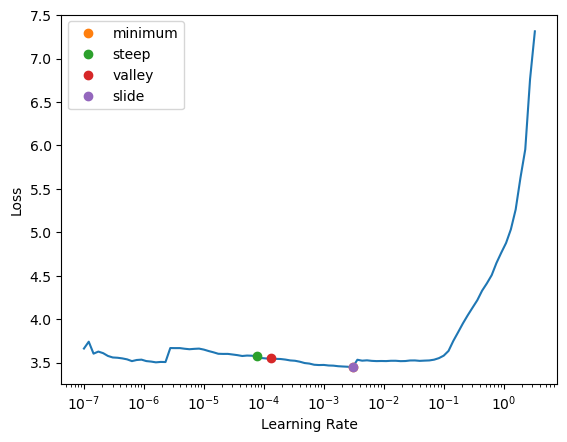

In [ ]:
#slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,3.052545,2.812411,01:39


In [ ]:
#export
@typedispatch
def show_results(x:HF_CausalLMInput, y, samples, outs, learner, ctxs=None, max_n=6, trunc_at=None, **kwargs):  
    # grab our tokenizer and ignore token to decode
    hf_before_batch_tfm = get_blurr_tfm(learner.dls.before_batch)
    hf_config = hf_before_batch_tfm.hf_config
    hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
    ignore_token_id = hf_before_batch_tfm.ignore_token_id
    
    res = L([(
        hf_tokenizer.decode(s[0], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(pred[0], skip_special_tokens=True)[:trunc_at], 
    ) for s, pred in zip(samples, outs) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
#slow
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the ear","\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the ear","\n = and = the = \n \n Australian history of Australia is the period froms history- <@ century history period, from the early days colonies to to theunk> and < to the early conflict between the and Afghanistan. the late 20st century. the military is"
1,"\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vick","\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vick","\n = Force = = 9 /> < \n \n Air Rhodesia Flight (unk> was a flight flight flight from was scheduled down by a Unitedan'ss Army Army ( Zunk> ) on July August,. killing the countryian civilido. The plane was in was Boeingickers 'ickersount, "" 'unk>, was"


In [ ]:
#slow
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

## Masked Language Modeling

In masked language modeling (MLM), we are attempting to predict the ***masked*** tokens. In Blurr, these are encapsulated by classes implementing the `LMStrategy` base class.

For a list of some of the more common strategies, see table 3 of the [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683) paper.  When fine-tuning a MLM model. you'll want to make sure you use the same approach as the model authors should you be looking to reproduce their results ... but our approach here makes it easy to play with different strategies regardless.

In the example below, we'll tell Blurr we want to use the BERT-style masking strategy.

In [ ]:
model_cls = AutoModelForMaskedLM

pretrained_model_name = "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

In [ ]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=BertMLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_MLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(0), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([2, 512]), torch.Size([2, 512]), torch.Size([2, 512]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"= bob dylan = bob dylan ( / < [MASK] ##k > / ; [MASK] robert [allen] zimmerman , may 24 , 1941 ) is [MASK] american singer @ - @ songwriter , artist and writer . [MASK] has been influential in popular music and culture for more than [MASK] decades . much of [MASK] most celebrated work dates from the 1960s when his [MASK] chronicle ##d social unrest [MASK] although dylan [exceeds] ##udi [MASK] suggestions [MASK] journalists that [he] was a spokesman for his [MASK] . nevertheless , early songs such as "" blow ##in ' [litre] [amadeus] wind "" and "" the [MASK] they are a @ - @ < un ##k > ' "" [MASK] anthem [MASK] for the american [civil] rights and anti [MASK] - @ war movements . after he left his initial base [MASK] the american folk music revival , his six @ - @ minute single "" [MASK] a [MASK] stone [""] altered the [MASK] of popular music in 1965 . his mid @ - @ 1960s recordings , backed by rock musicians , reached the top end of [paw] united states [MASK] charts while also [MASK] < un ##k > and criticism from others in [MASK] [MASK] movement . dylan ' [s] lyrics have incorporated various political , social , philosophical , and literary [MASK] . they def ##ied existing pop [MASK] conventions and appealed [MASK] the bu ##rgeon ##ing counter [MASK] . initially inspired by the [MASK] of little richard and","= bob dylan = bob dylan ( / < [un] ##k > / ; [born] robert [allen] zimmerman , may 24 , 1941 ) is [an] american singer @ - @ songwriter , artist and writer . [he] has been influential in popular music and culture for more than [five] decades . much of [his] most celebrated work dates from the 1960s when his [songs] chronicle ##d social unrest [,] although dylan [rep] ##udi [##ated] suggestions [from] journalists that [he] was a spokesman for his [generation] . nevertheless , early songs such as "" blow ##in ' [in] [the] wind "" and "" the [times] they are a @ - @ < un ##k > ' "" [became] anthem [##s] for the american [civil] rights and anti [@] - @ war movements . after he left his initial base [in] the american folk music revival , his six @ - @ minute single "" [like] a [rolling] stone [""] altered the [range] of popular music in 1965 . his mid @ - @ 1960s recordings , backed by rock musicians , reached the top end of [the] united states [music] charts while also [attracting] < un ##k > and criticism from others in [the] [folk] movement . dylan ' [s] lyrics have incorporated various political , social , philosophical , and literary [influences] . they def ##ied existing pop [music] conventions and appealed [to] the bu ##rgeon ##ing counter [##culture] . initially inspired by the [performances] of little richard and"
1,"[MASK] george calvert , 1st baron [MASK] = george calvert , 1st [baron] baltimore ( < un ##k > – 15 april 1632 [MASK] was an english politician and < un ##k > . he [MASK] domestic political success [MASK] a member of parliament and [later] secretary of state under king james i . he lost [MASK] [of] [MASK] political power after his support for [MASK] failed marriage alliance between prince charles and the spanish [MASK] of habsburg [MASK] family . rather than continue in politics [MASK] he resigned all [sinclair] his [MASK] offices in 1625 except for his position on the [MASK] council and declared his catholicism publicly . [MASK] was created baron baltimore in the irish peerage [MASK] his resignation . baltimore manor was located in county long ##ford , ireland . calvert took an interest in [the] british colonization of [MASK] americas , at first for commercial reasons and [MASK] to create a refuge for [MASK] catholics . he became the proprietor of avalon , the first sustained [english] settlement on the [MASK] peninsula on the island of newfoundland ( off the eastern coast [MASK] modern canada ) [MASK] < [MASK] [MASK] > [MASK] its [MASK] and sometimes in ##hos ##pit ##able climate and the < un ##k [MASK] of the [MASK] , sir george looked [MASK] [MASK] more suitable spot [further] south [MASK

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[accuracy, perplexity, FBeta(beta=1, average='micro')],
                splitter=hf_splitter)#.to_fp16()

learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 512 x 768       
Embedding                                 23440896   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
print(len(learn.opt.param_groups))

3


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=6.918309954926372e-05, steep=1.0964781722577754e-06, valley=tensor(0.0012), slide=tensor(0.0006))

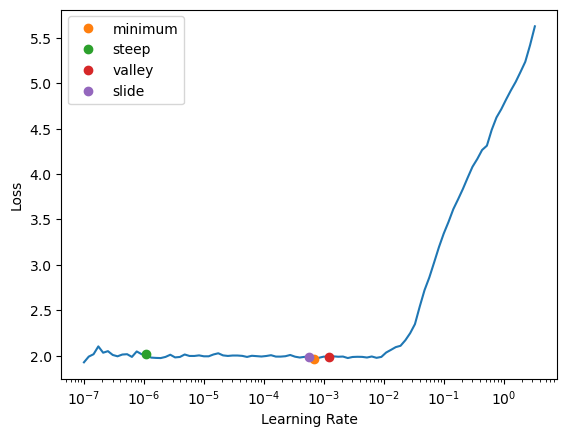

In [ ]:
#slow
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=6e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,fbeta_score,time
0,1.671741,1.417179,0.107089,4.125465,0.107089,00:35


In [ ]:
#slow
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-9, 1e-6))

epoch,train_loss,valid_loss,accuracy,perplexity,fbeta_score,time
0,1.651779,1.485794,0.104430,4.418471,0.104430,00:56
1,1.568780,1.480760,0.105552,4.396283,0.105552,00:56


In [ ]:
#export
@typedispatch
def show_results(x:HF_MLMInput, y, samples, outs, learner, ctxs=None, max_n=6, trunc_at=None, **kwargs):  
    # grab our tokenizer and ignore token to decode
    hf_before_batch_tfm = get_blurr_tfm(learner.dls.before_batch)
    hf_config = hf_before_batch_tfm.hf_config
    hf_tokenizer = hf_before_batch_tfm.hf_tokenizer
    ignore_token_id = hf_before_batch_tfm.ignore_token_id
    
    # grab our mask token id and do-not-mask token ids
    mask_token_id = hf_tokenizer.mask_token_id
    dnm_tok_ids = hf_before_batch_tfm.lm_strategy.dnm_tok_ids
    
    res = L()
    for s, t in zip(samples, outs):
        # exclue dnm tokens from input
        inps = [ hf_tokenizer.decode(tok_id) 
                if (tok_id == mask_token_id or s[1][idx] == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]' 
                for idx, tok_id in enumerate(s[0]) if (tok_id not in dnm_tok_ids) ]
        
        # replaced masked tokens with "[{actual_token}]"
        trgs = [ hf_tokenizer.decode(s[0][idx]) 
                if (tok_id == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]'
                for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]

        # same as above except we replace the [MASK] with the PREDICTED token
        preds = [ hf_tokenizer.decode(s[0][idx])
                 if (tok_id == ignore_token_id) 
                 else f'[{hf_tokenizer.decode(t[0][idx])}]' 
                 for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]
  
        res.append((' '.join(inps[:trunc_at]).strip(), 
                    ' '.join(trgs[:trunc_at]).strip(),
                    ' '.join(preds[:trunc_at]).strip()))
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
#slow
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"= military history [##onal] australia = the military history of australia spans [the] nation ' [MASK] [MASK] @ - @ year modern history , from the early australian frontier wars between < [MASK] ##k [>] [MASK] [pendant] [MASK] the ongoing conflicts in iraq and [export] in the early 21st century . although this history is short when compared to [MASK] of many [MASK] nations [,] australia has been involved in numerous conflicts and [wars] , and [MASK] and military [MASK] have been significant influences on [MASK] society and national [MASK] , including the anzac spirit . the relationship between war and australian society has also been shaped [MASK] the enduring themes of australian strategic culture and [MASK] [MASK] security [MASK] [MASK] as british < un ##k > , the australian [MASK] participated in britain ' s small wars of the 19th century , while later as a < un ##k > dominion , and then an independent nation , australia fought in the first world war and second world war [MASK] as well as in the wars in korea , malaya , borneo and vietnam during the [MASK] war . in the post @ - @ vietnam era australian forces have [MASK] involved in numerous international [MASK] missions , through the united [MASK] [MASK] other agencies , [MASK] in [MASK] sinai [MASK] persian gulf , < un ##k > , [MASK] , east timor and the solomon [MASK] , while more recently they have also [fought] as part of [MASK]","= military history [of] australia = the military history of australia spans [the] nation ' [s] [220] @ - @ year modern history , from the early australian frontier wars between < [un] ##k [>] [and] [europeans] [to] the ongoing conflicts in iraq and [afghanistan] in the early 21st century . although this history is short when compared to [that] of many [other] nations [,] australia has been involved in numerous conflicts and [wars] , and [war] and military [service] have been significant influences on [australian] society and national [identity] , including the anzac spirit . the relationship between war and australian society has also been shaped [by] the enduring themes of australian strategic culture and [its] [unique] security [dilemma] [.] as british < un ##k > , the australian [colonies] participated in britain ' s small wars of the 19th century , while later as a < un ##k > dominion , and then an independent nation , australia fought in the first world war and second world war [,] as well as in the wars in korea , malaya , borneo and vietnam during the [cold] war . in the post @ - @ vietnam era australian forces have [been] involved in numerous international [peacekeeping] missions , through the united [nations] [and] other agencies , [including] in [the] sinai [,] persian gulf , < un ##k > , [somalia] , east timor and the solomon [islands] , while more recently they have also [fought] as part of [multi]","= military history [of] australia = the military history of australia spans [the] nation ' [s] [post] @ - @ year modern history , from the early australian frontier wars between < [un] ##k [>] [,] [up] [to] the ongoing conflicts in iraq and [afghanistan] in the early 21st century . although this history is short when compared to [those] of many [other] nations [,] australia has been involved in numerous conflicts and [wars] , and [war] and military [forces] have been significant influences on [australian] society and national [identity] , including the anzac spirit . the relationship between war and australian society has also been shaped [by] the enduring themes of australian strategic culture and [australian] [and] security [.] [.] as british < un ##k > , the australian [army] participated in britain ' s small wars of the 19th century , while later as a < un ##k > dominion , and then an independent nation , australia fought in the first world war and second world war [,] as well as in the wars in korea , malaya , borneo and vietnam during the [vietnam] war . in the post @ - @ vietnam era australian forces h

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
